The original notebook is available at [Kaggle](https://www.kaggle.com/whitepaper-prompt-engineering), which use the Gemini API and AI Studio.
In my notebook, I will use LangChain to call chatgpt API. 

# Day 1 - Prompting with LlamaIndex and Azure Open AI

Welcome to the 5-day Generative AI course!
This notebook will show you how to get started with LlamIndex and ChatGPT, walking you through example prompts and techniques for effective prompting. This interactive notebook will give you hands-on experience with prompting techniques and best practices.

## Before you begin
To run this notebook, you need 
- An Azure subscriptino
- Create an Azure AI studio
- Create an Azure OpenAI model

Please follow https://learn.microsoft.com/en-us/azure/ai-studio/quickstarts/get-started-playground

If you don't want to create an Azure Subscription, you can use OpenAI API from https://platform.openai.com/signup directly.

In this notebook, you'll explore prompts and prompt parameters using LlamaIndex with Azure OpenAI's ChatGPT model. LlamaIndex is a framework for developing applications powered by language models, providing convenient abstractions for working with various LLMs including ChatGPT. You'll learn how to:

- Set up Llama with Azure OpenAI
- Create different types of prompts
- Work with structured outputs
- Generate codes

## Get Started with LlamaIndex and Azure OpenAI
All exercises in this notebook will use LangChain with ChatGPT. Let's start by setting up our environment and required packages.

### Setup and Configure
First, let's install the required packages and set up our environment.

In [1]:
%pip install -q llama-index llama-index-core llama-index-llms-azure-openai python-dotenv 

Note: you may need to restart the kernel to use updated packages.


In [4]:
from dotenv import load_dotenv
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.core.chat_engine import SimpleChatEngine
from llama_index.core.memory import ChatMemoryBuffer
from llama_index.core import (
    PromptTemplate
)
from enum import Enum
from llama_index.program.openai import OpenAIPydanticProgram
from pydantic import BaseModel
from typing import List

Load environment variable from .env file.
```
os.environ["AZURE_OPENAI_ENDPOINT"] = "YOUR_AZURE_ENDPOINT"
os.environ["AZURE_OPENAI_API_KEY"] = "YOUR_API_KEY"
os.environ["OPENAI_API_VERSION"] = "YOUR_API_VERSION"
```

In [2]:
load_dotenv()
# initialize the Azure OpenAI model
# Initialize Azure OpenAI model
llm = AzureOpenAI(
    model="gpt-4o",
    engine="gpt-4o",
    temperature=0.7
)

# # Create global settings
# Settings.llm = llm

## Basic Text Generation
Let's start with a simple example of text generation.

In [9]:
prompt = "Explain AI to me like I'm a kid."
response = llm.complete(prompt)
print(response)
    

Sure! Imagine you have a really smart robot friend. This robot friend can learn new things just like you do. When you show it pictures, tell it stories, or ask it questions, it gets better and better at understanding and helping you.

AI, or artificial intelligence, is like the brain of that smart robot friend. It's a special kind of computer program that can learn from lots of information, just like how you learn from books and experiences. So, when you see a robot that can talk, play games, or even help you find things, it's because of AI! It's like giving the robot a superpower to think and learn.


## Chat functionality with Memory
Have a conversation with LLM. This does not make use of knowledge base

In [6]:
def create_chat_engine():
    """Create a new chat engine with memory."""
    memory = ChatMemoryBuffer.from_defaults(token_limit=1500)
    
    chat_engine = SimpleChatEngine.from_defaults(
        memory=memory,
        llm=llm,
        system_prompt="You are a helpful AI assistant who can answer questions and provide information." 
    )
    return chat_engine

# Example
chat_engine = create_chat_engine()
response = chat_engine.chat("Hello! My name is Jackie.")
print(response)
print('------------------------------------------------')
response = chat_engine.chat("Can you tell something interesting about dinosaurs?")
print(response)
print('------------------------------------------------')
response = chat_engine.chat("Do you remember what my name is?")
print(response)

Hello, Jackie! How can I assist you today?
------------------------------------------------
Absolutely, Jackie! Dinosaurs are a fascinating subject. Did you know that the Tyrannosaurus rex, one of the most well-known dinosaurs, had a bite force estimated to be around 12,800 pounds? That’s about the weight of nearly six average cars! Additionally, some dinosaurs, like the Stegosaurus, had brains that were significantly smaller than what you'd expect for their body size. In fact, its brain was roughly the size of a walnut, despite the Stegosaurus being about 30 feet long! Dinosaurs roamed the Earth for about 165 million years, much longer than humans have been around. They continue to capture our imagination and provide valuable insights into the history of life on our planet.
------------------------------------------------
Yes, your name is Jackie. How can I assist you further?


## Explore generation parameters

### Output length

When generating text with an LLM, the output length affects cost and performance. Generating more tokens increases computation, leading to higher energy consumption, latency, and cost.

To stop the model from generating tokens past a limit, you can specify the `max_tokens` parameter when using the Azure Open AI. Specifying this parameter does not influence the generation of the output tokens, so the output will not become more stylistically or textually succinct, but it will stop generating tokens once the specified length is reached. Prompt engineering may be required to generate a more complete output for your given limit.

In [7]:
short_model = AzureOpenAI(model="gpt-4o", engine="gpt-4o", max_tokens=50)
response = short_model.complete("Write a 1000 word essay on the importance of olives in modern society.")
print(response.text)

Title: The Importance of Olives in Modern Society

Introduction

Olives, the small, oval fruits of the Olea europaea tree, have been cultivated for thousands of years and hold a significant place in human history. Originating from the Mediterranean


In [8]:
response = short_model.complete("Write a short poem on the importance of olives in modern society.")
print(response.text)

In groves where ancient whispers weave,
The olive trees their secrets leave.
With branches bent by time's embrace,
They offer gifts of peace and grace.

Their fruits, like gems in twilight's glow,
Hold stories from the lands below.
In kitchens


Prompt with a restrictive output length.

In [11]:
short_model = AzureOpenAI(model="gpt-4o", engine="gpt-4o", max_tokens=50)
response = short_model.complete("Write a 30 word essay on the importance of olives in modern society.")
print(response.text)

Olives play a crucial role in modern society, offering health benefits through their rich nutrients and antioxidants. They are essential in culinary traditions, contributing to diverse cuisines and supporting agricultural economies globally.


### Temperature

Temperature controls the degree of randomness in token selection. Higher temperatures result in a higher number of candidate tokens from which the next output token is selected, and can produce more diverse results, while lower temperatures have the opposite effect, such that a temperature of 0 results in greedy decoding, selecting the most probable token at each step.

Temperature is processed by scaling the logist before the softmax operation.
The standard softmax function without temperature:
$$P(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}$$
where $z_i$ is the logit of the $i$-th token.

**Temperature-Scaled Softmax** with temperature $T$:
$$P(z_i) = \frac{e^{z_i/T}}{\sum_{j=1}^{n} e^{z_j/T}}$$

**The best practice**
   - coding: $T: 0.2 - 0.3$
   - Q&A: $T: 0.3 - 0.5$
   - creative writing: $T: 0.7-0.9$



In [16]:
# When running lots of queries, it's a good practice to use a retry policy so your code. Add retry and timeout parameters to the model initialization.
# OpenAI temperature parameter is between 0 and 1
high_temp_model = AzureOpenAI(model="gpt-4o", 
                              engine="gpt-4o", 
                              temperature=1, 
                              retry=3,
                              timeout=10)

for _ in range(5):
    response = high_temp_model.complete("Pick a random colour... (respond in a single word)")
    print(response.text)
    print('-' * 25)

Turquoise.
-------------------------
Azure
-------------------------
Cerulean
-------------------------
Azure
-------------------------
Turquoise
-------------------------


In [17]:
# try with a lower temperature
low_temp_model = AzureOpenAI(model="gpt-4o", 
                             engine="gpt-4o", 
                             temperature=0,
                             retry=3,
                             timeout=10)
for _ in range(5):
    response = low_temp_model.complete("Pick a random colour... (respond in a single word)")
    print(response.text)
    print('-' * 25)

Turquoise
-------------------------
Turquoise
-------------------------
Turquoise
-------------------------
Turquoise
-------------------------
Turquoise
-------------------------


### Top-K and top-P

Like temperature, top-K and top-P parameters are also used to control the diversity of the model's output.

Top-K is a positive integer that defines the number of most probable tokens from which to select the output token. A top-K of 1 selects a single token, performing greedy decoding.

Top-P defines the probability threshold that, once cumulatively exceeded, tokens stop being selected as candidates. A top-P of 0 is typically equivalent to greedy decoding, and a top-P of 1 typically selects every token in the model's vocabulary.

When both are supplied, the Gemini API will filter top-K tokens first, then top-P and then finally sample from the candidate tokens using the supplied temperature.

In [20]:
model = AzureOpenAI(model="gpt-4o", 
                    engine="gpt-4o", 
                    temperature=1.0,
                    max_retries=3,
                    timeout=300,
                    top_k=64, 
                    top_p=0.95)
response = model.complete("You are a creative writer. Write a short story about a cat who goes on an adventure.")
print(response.text)

Once upon a time in the quaint village of Whiskerbell, where the cobblestone streets twisted like a forgotten fairy tale, there lived a curious cat named Oliver. Oliver was not an ordinary cat; he was an adventurer at heart. With his fur as white as freshly fallen snow and his emerald eyes sparkling like hidden treasures, Oliver had an insatiable curiosity for the world beyond his cozy home.

Oliver lived with an elderly woman named Miss Beatrix, who often recounted tales of her own youthful escapades. Each night, as the fire crackled and cast dancing shadows on the walls, she would whisper stories of far-off lands and mysterious creatures. These stories stirred something deep within Oliver, and he longed to forge his own path to adventure.

One crisp morning, as the first rays of sunlight kissed the rooftops of Whiskerbell, Oliver made up his mind. With a determined flick of his tail, he slipped through the slightly ajar door and into the world beyond.

He trotted down the winding str

In [22]:
# try with a lower top-k and top-p
model = AzureOpenAI(model="gpt-4o", 
                    engine="gpt-4o", 
                    temperature=0,
                    max_retries=3,
                    timeout=300,
                    top_k=1, 
                    top_p=0)
response = model.complete("You are a creative writer. Write a short story about a cat who goes on an adventure.")
print(response.text)

Once upon a time, in a quaint little village nestled between rolling hills and whispering forests, lived a curious cat named Whiskers. Whiskers was no ordinary cat; he had a heart full of wanderlust and a spirit that yearned for adventure. His sleek, black fur and piercing green eyes made him a striking figure, but it was his insatiable curiosity that truly set him apart.

One crisp autumn morning, as the golden leaves danced in the breeze, Whiskers decided it was time to explore beyond the familiar cobblestone streets and cozy cottages of his village. He had heard tales of a magical forest that lay just beyond the hills, a place where the trees whispered secrets and the streams sang lullabies. With a determined flick of his tail, Whiskers set off on his grand adventure.

As he ventured deeper into the forest, the air grew cooler and the light dimmer. The trees, tall and ancient, seemed to watch him with knowing eyes. Whiskers trotted along a winding path, his ears perked up and his wh

## Prompting

This section contains some prompts from the chapter for you to try out directly in the API. Try changing the text here to see how each prompt performs with different instructions, more examples, or any other changes you can think of.

### Zero-shot

Zero-shot prompts are prompts that describe the request for the model directly.

In [71]:
model = AzureOpenAI(
    model="gpt-4o",
    engine="gpt-4o",
    temperature=0.1,
    top_p=1,
    max_tokens=10,
)
zero_shot_prompt = """Classify movie reviews as POSITIVE, NEUTRAL or NEGATIVE.
Review: "Her" is a disturbing study revealing the direction
humanity is headed if AI is allowed to keep evolving,
unchecked. I wish there were more movies like this masterpiece.
Sentiment: """
response = model.complete(zero_shot_prompt)
print(response.text)

Sentiment: POSITIVE


#### Enum Output Parsing

The models are trained to generate text, and can sometimes produce more text than you may wish for. In the preceding example, the model will output the label, sometimes it can include a preceding "Sentiment" label, and without an output token limit, it may also add explanatory text afterward.

For enum-based output parsing, we'll use LlamaIndex's OpenAIPydanticProgram which can handle enums through Pydantic models.

In [81]:
class sentiment_enum(str, Enum):
    POSITIVE = "positive"
    NEUTRAL = "neutral"
    NEGATIVE = "negative"
    
class SentimentResponse(BaseModel):
    sentiment: sentiment_enum

response = OpenAIPydanticProgram.from_defaults(
    output_cls=SentimentResponse,
    prompt_template_str="Classify movie reviews as POSITIVE, NEUTRAL or NEGATIVE.\nReview: {review}",
    llm=model,
    verbose=True,
)
output = response(review="""  "Her" is a disturbing study revealing the direction
humanity is headed if AI is allowed to keep evolving,
unchecked. I wish there were more movies like this masterpiece.
 poSentiment:""", description='sentiment')
print(output.sentiment.value)

Function call: SentimentResponse with args: {"sentiment":"positive"}
positive


### One-shot and few-shot

Providing an example of the expected response is known as a "one-shot" prompt. When you provide multiple examples, it is a "few-shot" prompt.

In [83]:
llm = AzureOpenAI(
    model="gpt-4o",
    engine="gpt-4o",
    temperature=0.1,
    top_p=1,
    max_tokens=250,
)
prompt = """
Parse a customer's pizza order into valid JSON:

EXAMPLE:
I want a small pizza with cheese, tomato sauce, and pepperoni.
JSON Response:
```
{
"size": "small",
"type": "normal",
"ingredients": ["cheese", "tomato sauce", "peperoni"]
}
```

EXAMPLE:
Can I get a large pizza with tomato sauce, basil and mozzarella
JSON Response:
```
{
"size": "large",
"type": "normal",
"ingredients": ["tomato sauce", "basil", "mozzarella"]
}

ORDER: Give me a large with cheese & pineapple
"""
response = llm.complete(prompt)
print(response.text)

```
{
  "size": "large",
  "type": "normal",
  "ingredients": ["cheese", "pineapple"]
}
```


#### Json Output


We can parse the output JSON using Pydantic models.

In [93]:
class PizzaOrder(BaseModel):
    size: str
    type: str
    ingredients: List[str]
    
parse_pizza_order = OpenAIPydanticProgram.from_defaults(
    output_cls=PizzaOrder,
    prompt_template_str="""Convert this pizza order into structured data with size, type, and ingredients.\nOrder: {pizza_order}""",
    llm=llm,
    verbose=True,
)
output = parse_pizza_order(description='pizza order', pizza_order='Can I have a large dessert pizza with apple and chocolate?')
output.dict()

Function call: PizzaOrder with args: {"size":"large","type":"dessert","ingredients":["apple","chocolate"]}


{'size': 'large', 'type': 'dessert', 'ingredients': ['apple', 'chocolate']}

### Chain of Thought (CoT)

Direct prompting on LLMs can return answers quickly and (in terms of output token usage) efficiently, but they can be prone to hallucination. The answer may "look" correct (in terms of language and syntax) but is incorrect in terms of factuality and reasoning.

Chain-of-Thought prompting is a technique where you instruct the model to output intermediate reasoning steps, and it typically gets better results, especially when combined with few-shot examples. It is worth noting that this technique doesn't completely eliminate hallucinations, and that it tends to cost more to run, due to the increased token count.

In [94]:
prompt = """When I was 4 years old, my partner was 3 times my age. Now, I
am 20 years old. How old is my partner? Return the answer immediately."""
response = llm.complete(prompt)
print(response.text)

When you were 4 years old, your partner was 3 times your age, which means your partner was 4 * 3 = 12 years old at that time. The difference in age between you and your partner is 12 - 4 = 8 years.

Now that you are 20 years old, your partner is 20 + 8 = 28 years old.


In [95]:
prompt = """When I was 4 years old, my partner was 3 times my age. Now,
I am 20 years old. How old is my partner? Let's think step by step."""
response = llm.complete(prompt)
print(response.text)

Sure, let's break it down step by step.

1. When you were 4 years old, your partner was 3 times your age.
   - Your age: 4 years old
   - Your partner's age: 3 times 4 = 12 years old

2. The difference in age between you and your partner is:
   - 12 years old (partner's age) - 4 years old (your age) = 8 years

3. Now, you are 20 years old.
   - Since the age difference remains constant, your partner is:
   - Your age (20 years) + 8 years (age difference) = 28 years old

Therefore, your partner is 28 years old now.


### ReAct Pattern Implementation
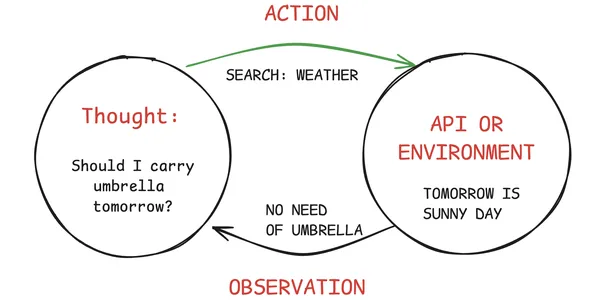

What is ReAct Pattern?
ReAct (Reasoning and Acting) is a prompting strategy that combines:

- Reasoning: Breaking down complex problems into steps
- Acting: Taking specific actions based on the reasoning
- Observation: Recording results from actions
- Final Answer: Providing conclusions based on the process

This pattern is particularly useful for:
- Complex problem-solving that requires multiple steps
- Tasks that need both analysis and information gathering
- Situations where showing work is as important as the final answer

> Note: The prompt and in-context examples used here are from [https://github.com/ysymyth/ReAct](https://github.com/ysymyth/ReAct) which is published under a [MIT license](https://opensource.org/licenses/MIT), Copyright (c) 2023 Shunyu Yao.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/18oo63Lwosd-bQ6Ay51uGogB3Wk3H8XMO"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>


In [6]:
model_instructions = """
Solve a question answering task with interleaving Thought, Action, Observation steps. Thought can reason about the current situation,
Observation is understanding relevant information from an Action's output and Action can be one of three types:
 (1) <search>entity</search>, which searches the exact entity on Wikipedia and returns the first paragraph if it exists. If not, it
     will return some similar entities to search and you can try to search the information from those topics.
 (2) <lookup>keyword</lookup>, which returns the next sentence containing keyword in the current context. This only does exact matches,
     so keep your searches short.
 (3) <finish>answer</finish>, which returns the answer and finishes the task.
"""

example1 = """Question
Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?

Thought 1
The question simplifies to "The Simpsons" character Milhouse is named after who. I only need to search Milhouse and find who it is named after.

Action 1
<search>Milhouse</search>

Observation 1
Milhouse Mussolini Van Houten is a recurring character in the Fox animated television series The Simpsons voiced by Pamela Hayden and created by Matt Groening.

Thought 2
The paragraph does not tell who Milhouse is named after, maybe I can look up "named after".

Action 2
<lookup>named after</lookup>

Observation 2
Milhouse was named after U.S. president Richard Nixon, whose middle name was Milhous.

Thought 3
Milhouse was named after U.S. president Richard Nixon, so the answer is Richard Nixon.

Action 3
<finish>Richard Nixon</finish>
"""

example2 = """Question
What is the elevation range for the area that the eastern sector of the Colorado orogeny extends into?

Thought 1
I need to search Colorado orogeny, find the area that the eastern sector of the Colorado orogeny extends into, then find the elevation range of the area.

Action 1
<search>Colorado orogeny</search>

Observation 1
The Colorado orogeny was an episode of mountain building (an orogeny) in Colorado and surrounding areas.

Thought 2
It does not mention the eastern sector. So I need to look up eastern sector.

Action 2
<lookup>eastern sector</lookup>

Observation 2
The eastern sector extends into the High Plains and is called the Central Plains orogeny.

Thought 3
The eastern sector of Colorado orogeny extends into the High Plains. So I need to search High Plains and find its elevation range.

Action 3
<search>High Plains</search>

Observation 3
High Plains refers to one of two distinct land regions

Thought 4
I need to instead search High Plains (United States).

Action 4
<search>High Plains (United States)</search>

Observation 4
The High Plains are a subregion of the Great Plains. From east to west, the High Plains rise in elevation from around 1,800 to 7,000 ft (550 to 2,130m).

Thought 5
High Plains rise in elevation from around 1,800 to 7,000 ft, so the answer is 1,800 to 7,000 ft.

Action 5
<finish>1,800 to 7,000 ft</finish>
"""

# Come up with more examples yourself, or take a look through https://github.com/ysymyth/ReAct/

In [10]:
# Create the prompt template
prompt = PromptTemplate(
    template="""
Solve the question by following the instructions below:
{model_instructions}
There are two examples below to help you understand the format:
Example 1:
{example1}
Example 2:
{example2}
Question: {question}
""")

# Format the prompt using the format method
formatted_prompt = prompt.format(
    model_instructions=model_instructions,
    example1=example1,
    example2=example2,
    question="Who was the youngest author listed on the transformers NLP paper?"
)

response = llm.complete(formatted_prompt)
print(response.text)

Thought 1
I need to search for the Transformers NLP paper and find the list of authors. Once I have the list, I can determine who the youngest author is.

Action 1
<search>Transformers NLP paper</search>

Observation 1
"Attention Is All You Need" is the title of the paper that introduced the Transformer model. The authors listed on the paper are Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin.

Thought 2
I have the list of authors from the Transformers NLP paper. Now, I need to determine who the youngest author is. I will search for the birth dates or ages of each author to find out who is the youngest.

Action 2
<search>Ashish Vaswani birth date</search>

Observation 2
There is no specific information on Ashish Vaswani’s birth date readily available.

Thought 3
Since the birth date for Ashish Vaswani is not readily available, I will proceed by searching the birth dates or ages of the other authors to see if a

## Code Prompting

In [11]:
llm = AzureOpenAI(
    model="gpt-4o",
    engine="gpt-4o",
    temperature=1,
    top_p=1,
    max_tokens=1024,
)

code_prompt = """
Write a Python function to calculate the factorial of a number. No explanation, provide only the code.
"""
response = llm.complete(code_prompt)
print(response.text)

```python
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)
```


Azure OpenAI cannot automatically run generated code. 